# Practical Work: Fire Detection

In [1]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
# from torchsummary import summary

import matplotlib.pyplot as plt

from datasets import WildfirePredictionDataset

In [2]:
# Set random seed for reproducability and dataset splitting
torch.manual_seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Exploring Data

In [4]:
# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load Wildfire Prediction Dataset dataset
dataset = WildfirePredictionDataset(split="valid", transform=transform)
print(len(dataset))

6300


In [5]:
# Check sample sizes
sample_idx = torch.randint(len(dataset), size=(1,)).item()
img, label = dataset[sample_idx]
print(img.shape)
print(label)

torch.Size([3, 350, 350])
0


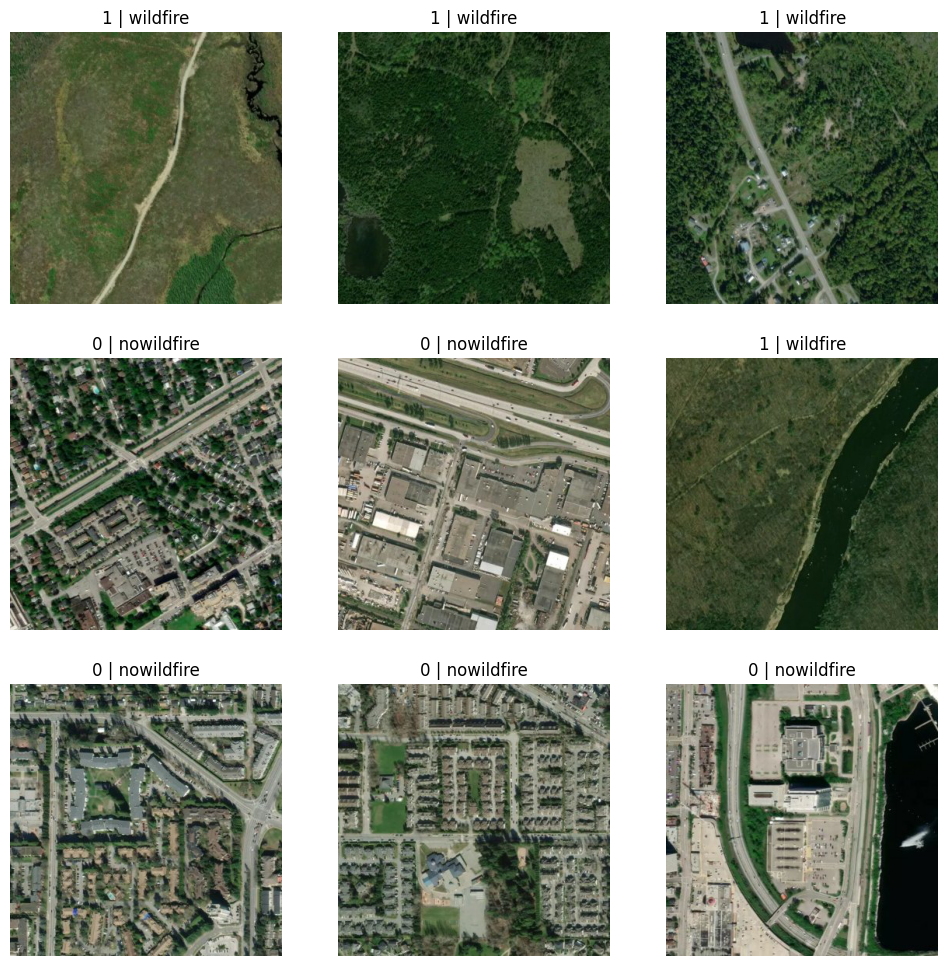

In [6]:
# Plot images and labels
cols, rows = 3, 3
figure = plt.figure(figsize=(cols*4, rows*4))
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label} | {dataset.labels_dict[label]}")
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
plt.show()

## Loading Data

In [ ]:
# Create training, validation and test data loaders
train_loader, valid_loader_1, valid_loader_2, test_loader = WildfirePredictionDataset.get_dataloaders(transform=transform, batch_size=16)

## SimCLR